In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from hurst import compute_Hc
from datetime import date, datetime
import os
from matplotlib.dates import MonthLocator, DateFormatter

In [2]:
#Set this to True if you want to see how this quarter's forecast is going with a cutoff of calendar year.
#Set it to False if you want forecasts to include data from this year
verify=True

In [3]:
# Function to remove the beginning of a string if it starts with "CVSS:3.1" or "CVSS:3.0"
def remove_cvss_prefix(vector):
    if vector is not np.NaN:
        return vector[8+1:]
    else:
        return vector

In [4]:
# Function to remove double quotes within a string
def remove_double_quotes(input_string):
    if input_string is not np.NaN:
        return input_string.replace('"', '')
    else:
        return input_string

In [5]:
# Import Data
df = pd.read_csv('NVD-Vulnerability-Volumes.csv',index_col=['Publication'],parse_dates=['Publication'],low_memory=False)
df.head()

,ID,ASSIGNER,DESCRIPTION,Count,v2 CVSS,v2 Vector,v2 Exploitability Score,v3 CVSS,v3 Vector,v3 Expoitability Score,CWE,v2.3 CPE
Publication,,,,,,,,,,,,
1999-12-30 05:00:00+00:00,CVE-1999-0001,"""cve@mitre.org""","""ip_input.c in BSD-derived TCP/IP implementati...",1.0,5.0,"""AV:N/AC:L/Au:N/C:N/I:N/A:P""",NaN,NaN,NaN,NaN,"""CWE-20""","['[""CVE-1999-0001""', ' ""cpe:2.3:o:freebsd:free..."
1998-10-12 04:00:00+00:00,CVE-1999-0002,"""cve@mitre.org""","""Buffer overflow in NFS mountd gives root acce...",1.0,10.0,"""AV:N/AC:L/Au:N/C:C/I:C/A:C""",NaN,NaN,NaN,NaN,"""CWE-119""","['[""CVE-1999-0002""', ' ""cpe:2.3:o:bsdi:bsd_os:..."
1998-04-01 05:00:00+00:00,CVE-1999-0003,"""cve@mitre.org""","""Execute commands as root via buffer overflow ...",1.0,10.0,"""AV:N/AC:L/Au:N/C:C/I:C/A:C""",NaN,NaN,NaN,NaN,"""NVD-CWE-Other""","['[""CVE-1999-0003""', ' ""cpe:2.3:o:sgi:irix:5.3..."
1997-12-16 05:00:00+00:00,CVE-1999-0004,"""cve@mitre.org""","""MIME buffer overflow in email clients, e.g. S...",1.0,5.0,"""AV:N/AC:L/Au:N/C:N/I:N/A:P""",NaN,NaN,NaN,NaN,"""NVD-CWE-Other""","['[""CVE-1999-0004""', ' ""cpe:2.3:a:university_o..."
1998-07-20 04:00:00+00:00,CVE-1999-0005,"""cve@mitre.org""","""Arbitrary command execution via IMAP buffer o...",1.0,10.0,"""AV:N/AC:L/Au:N/C:C/I:C/A:C""",NaN,NaN,NaN,NaN,"""NVD-CWE-Other""","['[""CVE-1999-0005""', ' ""cpe:2.3:a:netscape:mes..."


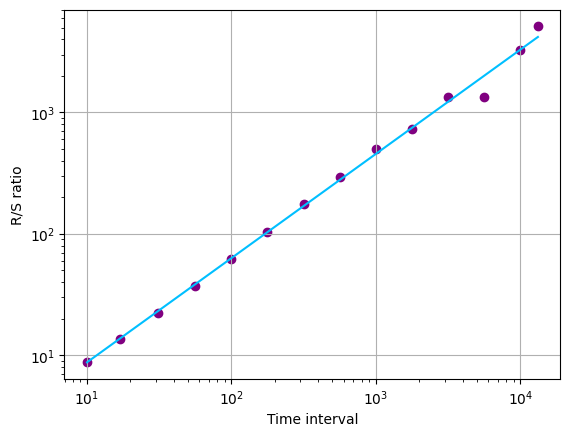

H=0.8585, c=1.2114


In [6]:
#Examine the data with the Hurst component to convinces ourselves this is possible (and lo0k at different timeframes of possibility)
H, c, data = compute_Hc(df['Count'].resample('D').sum(), kind='change',simplified=True)
# Plot
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))

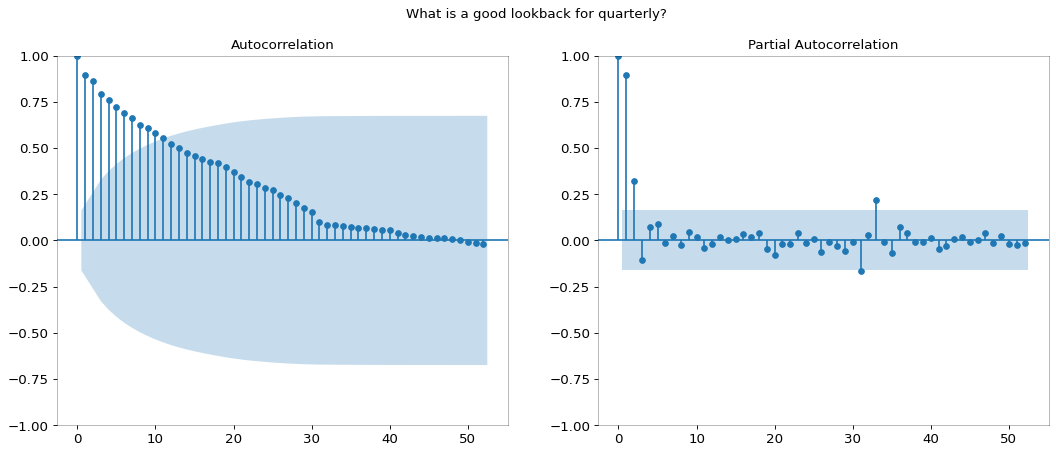

In [7]:
# Import Data
#df = all_vulns

# Draw Plot
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi= 80)
plot_acf(df['Count'].resample('Q').sum().tolist(), ax=ax1, lags=52)
plot_pacf(df['Count'].resample('Q').sum().tolist(), ax=ax2, lags=52)

# Decorate
# lighten the borders
ax1.spines["top"].set_alpha(.3); ax2.spines["top"].set_alpha(.3)
ax1.spines["bottom"].set_alpha(.3); ax2.spines["bottom"].set_alpha(.3)
ax1.spines["right"].set_alpha(.3); ax2.spines["right"].set_alpha(.3)
ax1.spines["left"].set_alpha(.3); ax2.spines["left"].set_alpha(.3)

# font size of tick labels
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
fig.suptitle("What is a good lookback for quarterly?")
plt.show()

In [8]:
if verify:
    #Make the cutoff the last date of last quarter
    last_quarter = df['Count'].resample('Q').max().fillna(method='bfill').index[-1].quarter-1 #-2
    this_quarter = df['Count'].resample('Q').max().fillna(method='bfill').index[-1].quarter #-1
    if last_quarter == 0 or this_quarter == 0:
        year = datetime.now().year - 1
        cutoff = datetime(year, 12, 31, 0, 0)
    elif last_quarter == 1:
        cutoff = datetime(datetime.now().year, 3, 31, 0, 0)
    else:
        cutoff = datetime(datetime.now().year, 3*this_quarter, 30, 0, 0)
    #We'll want to check our progress through the quarter so we do need that as a data set later
    check=df[df.index.tz_localize(None)>cutoff]
    #The data we'll predict from shouldn't contain any data for this quarter
    df=df[df.index.tz_localize(None)<=cutoff]
else:
#Make the cutoff the last date of last quarter
    last_quarter = df['Count'].resample('Q').max().fillna(method='bfill').index[-1].quarter-1
    this_quarter = df['Count'].resample('Q').max().fillna(method='bfill').index[-1].quarter
    if last_quarter == 0:
        year = datetime.now().year - 1
        cutoff = datetime(year, 12, 31, 0, 0)
    elif last_quarter == 1:
        cutoff = datetime(datetime.now().year, 3, 31, 0, 0)
    else:
        print('Last Case')
        cutoff = datetime(datetime.now().year, 3*this_quarter, 30, 0, 0)

    #We'll want to check our progress through the quarter so we do need that as a data set later
    check=df[df.index.tz_localize(None)>cutoff]
    #The data we'll predict from shouldn't contain any data for this quarter
    df=df[df.index.tz_localize(None)<=cutoff]
# Construct the model  seasonal_order=() BIC 2322 seasonal_order=(1, 4, 2, 4) BIC 2176
mod = sm.tsa.SARIMAX(df['Count'].resample('Q').sum(), order=(11,2,4), exog=None, trend='ct', freq="Q")
res = mod.fit(method="powell",maxiter=500,full_output=True)
print(res.summary())

/tmp/ipykernel_452276/1783082631.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  last_quarter = df['Count'].resample('Q').max().fillna(method='bfill').index[-1].quarter-1 #-2
/tmp/ipykernel_452276/1783082631.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  this_quarter = df['Count'].resample('Q').max().fillna(method='bfill').index[-1].quarter #-1
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Optimization terminated successfully.
         Current function value: 7.701005
         Iterations: 6
         Function evaluations: 1106
                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                  145
Model:              SARIMAX(11, 2, 4)   Log Likelihood               -1116.646
Date:                Sun, 05 Jan 2025   AIC                           2269.292
Time:                        14:21:57   BIC                           2322.623
Sample:                    12-31-1988   HQIC                          2290.963
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -71.1909    291.348     -0.244      0.807    -642.222     

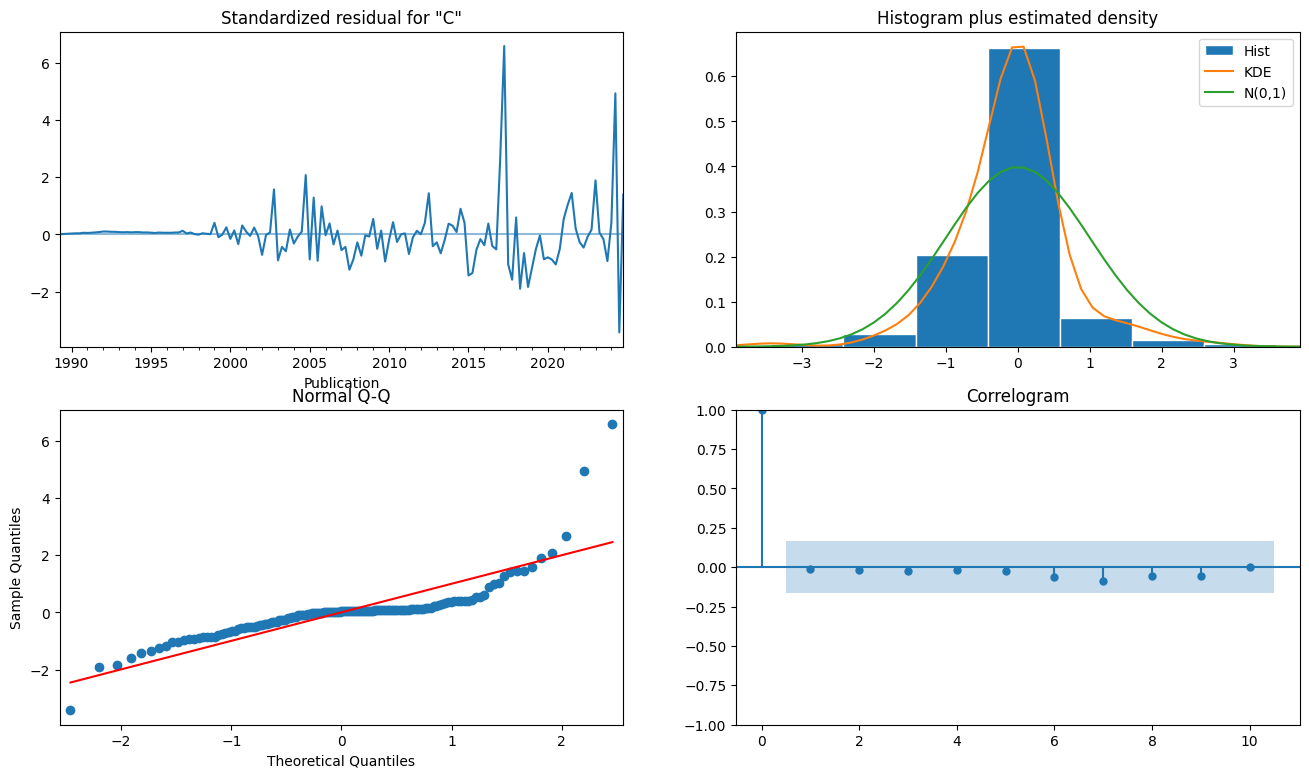

In [9]:
# Plot diagnostics
res.plot_diagnostics(figsize=(16, 9))
plt.show()

In [10]:
# Here we construct a more complete results object.
fcast_res1 = res.get_forecast(steps=4)

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 90%
print(fcast_res1.summary_frame(alpha=0.05))

Count                              mean     mean_se  mean_ci_lower  \
2025-03-31 00:00:00+00:00  11420.823054  589.152203   10266.105954   
2025-06-30 00:00:00+00:00  12130.017565  658.021383   10840.319354   
2025-09-30 00:00:00+00:00  12113.847218  722.755342   10697.272778   
2025-12-31 00:00:00+00:00  12581.691283  819.404008   10975.688938   

Count                      mean_ci_upper  
2025-03-31 00:00:00+00:00   12575.540154  
2025-06-30 00:00:00+00:00   13419.715777  
2025-09-30 00:00:00+00:00   13530.421659  
2025-12-31 00:00:00+00:00   14187.693628  


In [11]:
today = date.today()
current_datetime = today.strftime("%b-%d-%Y")
#Note this format will overwrite all forecasts produced on the same day
file_name = current_datetime+"-Quarterly-vuln4cast.csv"
path = 'QuarterlyForecasts/'
# Check whether the specified path exists or not
isExist = os.path.exists(path)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(path)
   print("The new directory is created!")
fcast_res1.summary_frame(alpha=0.05).to_csv(path+file_name)

In [12]:
df['v3 Vector'] = df['v3 Vector'].apply(remove_double_quotes)
df['v3 Vector'] = df['v3 Vector'].apply(remove_cvss_prefix)

In [13]:
mean_v3_vector_forecast = fcast_res1.summary_frame()['mean'].iloc[0]*df['v3 Vector'].value_counts(normalize=True)
lowerci_v3_vector_forecast = fcast_res1.summary_frame()['mean_ci_lower'].iloc[0]*df['v3 Vector'].dropna().value_counts(normalize=True)
upperci_v3_vector_forecast = fcast_res1.summary_frame()['mean_ci_upper'].iloc[0]*df['v3 Vector'].dropna().value_counts(normalize=True)

In [14]:
mean_v3_vector_forecast.to_csv(path+current_datetime+'-Quarterly-MeanV3VectorForecast.csv')
upperci_v3_vector_forecast.to_csv(path+current_datetime+'-Quarterly-UpperCIV3VectorForecast.csv')
lowerci_v3_vector_forecast.to_csv(path+current_datetime+'-Quarterly-LowerCIV3VectorForecast.csv')

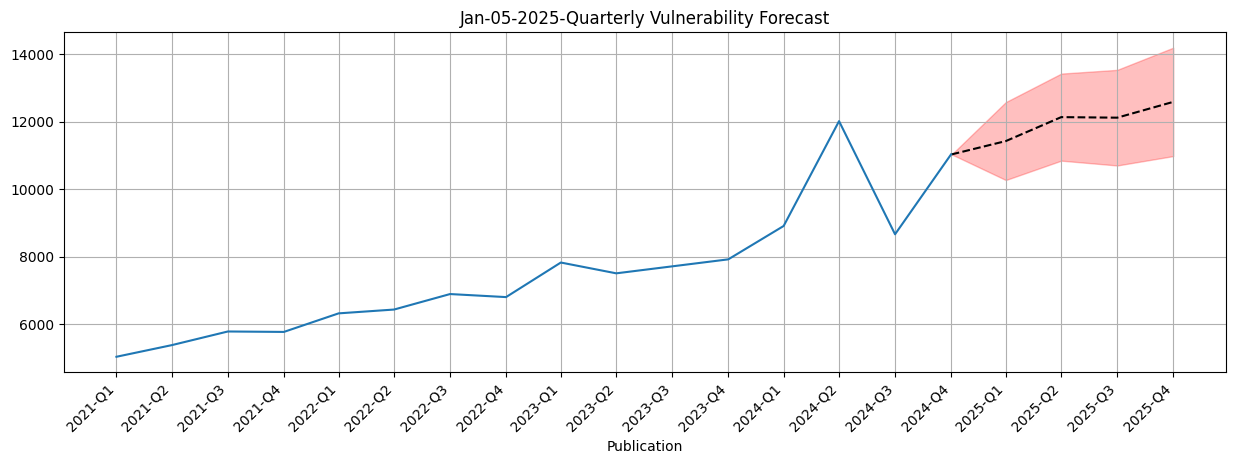

In [25]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.title(current_datetime+"-Quarterly Vulnerability Forecast")

# Plot the data (here we are subsetting it to get a closer look at the forecasts than the history)
quarterly_resample = df['Count'].resample('Q').sum()
# Construct the forecasts
fcast = res.get_forecast(steps=4).summary_frame()
interstitial_date = pd.Timestamp.today().to_period('Q').start_time.tz_localize('UTC')
new_row = pd.DataFrame(
    {'mean':df.resample('Q').Count.sum().iloc[-1], 
     'mean_se':fcast.mean_se.iloc[0], 
     'mean_ci_lower':df.resample('Q').Count.sum().iloc[-1], 
     'mean_ci_upper':df.resample('Q').Count.sum().iloc[-1]}, 
    index=[interstitial_date])
fcast = pd.concat([new_row,fcast.loc[:]])
fcast['mean'].plot(ax=ax, style='k--')
quarterly_resample.loc['2021Q1':].plot(ax=ax)
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='r', alpha=0.25);
ax.grid(which='both')
# Format x-axis for quarterly ticks
ticks = pd.date_range(start=quarterly_resample.index[-16], 
                     end=fcast.index[-1], 
                     freq='Q')
tick_labels = [f"{tick.year}-Q{tick.quarter}" for tick in ticks]

ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels, rotation=45)
image_name = current_datetime+"-Quarterly-vuln4cast.png"
plt.savefig(path+image_name)

In [16]:
#We need an end date for the forecast verification data frame
end = fcast_res1.summary_frame(alpha=0.05).index[0]

In [17]:
if end.tz is None:
    end = end.tz_localize('UTC')

# Make check index timezone-aware before comparison
if verify:
    if check.index.tz is None:
        check = check.tz_localize('UTC')
    check = check[check.index < end]  # Now both sides are timezone-aware
print(fcast_res1.summary_frame(alpha=0.05))
if verify:
    print('The current count of published NVD vulns is: '+str(check['Count'].sum()))
    print('The current difference is: '+str(check['Count'].sum()- fcast_res1.summary_frame()['mean'].iloc[0]))

Count                              mean     mean_se  mean_ci_lower  \
2025-03-31 00:00:00+00:00  11420.823054  589.152203   10266.105954   
2025-06-30 00:00:00+00:00  12130.017565  658.021383   10840.319354   
2025-09-30 00:00:00+00:00  12113.847218  722.755342   10697.272778   
2025-12-31 00:00:00+00:00  12581.691283  819.404008   10975.688938   

Count                      mean_ci_upper  
2025-03-31 00:00:00+00:00   12575.540154  
2025-06-30 00:00:00+00:00   13419.715777  
2025-09-30 00:00:00+00:00   13530.421659  
2025-12-31 00:00:00+00:00   14187.693628  
The current count of published NVD vulns is: 439.0
The current difference is: -10981.823054015847


In [18]:
mean_v3_vector_forecast = fcast_res1.summary_frame()['mean'].iloc[0]*df['v3 Vector'].dropna().value_counts(normalize=True)
lowerci_v3_vector_forecast = fcast_res1.summary_frame()['mean_ci_lower'].iloc[0]*df['v3 Vector'].dropna().value_counts(normalize=True)
upperci_v3_vector_forecast = fcast_res1.summary_frame()['mean_ci_upper'].iloc[0]*df['v3 Vector'].dropna().value_counts(normalize=True)

In [19]:
check['v3 Vector'] = check['v3 Vector'].astype(str).apply(remove_double_quotes)
check['v3 Vector'] = check['v3 Vector'].astype(str).apply(remove_cvss_prefix)
actual = check['v3 Vector'].value_counts()

In [20]:
predicted = mean_v3_vector_forecast

In [21]:
if len(actual) > 0: 
    mean_v3_vector_forecast = pd.merge(mean_v3_vector_forecast, actual, left_index=True, right_index=True, validate="1:1")
    mean_v3_vector_forecast = mean_v3_vector_forecast.rename(columns={"v3 Vector_x": "Predicted", "v3 Vector_y": "Actual"})
    lowerci_v3_vector_forecast = pd.merge(lowerci_v3_vector_forecast, actual, left_index=True, right_index=True, validate="1:1")
    lowerci_v3_vector_forecast = lowerci_v3_vector_forecast.rename(columns={"v3 Vector_x": "Predicted", "v3 Vector_y": "Actual"})
    upperci_v3_vector_forecast = pd.merge(upperci_v3_vector_forecast, actual, left_index=True, right_index=True, validate="1:1")
    upperci_v3_vector_forecast = upperci_v3_vector_forecast.rename(columns={"v3 Vector_x": "Predicted", "v3 Vector_y": "Actual"})

In [22]:
mean_v3_vector_forecast.to_csv('verify_quarterly_mean_v3_vector.csv')
lowerci_v3_vector_forecast.to_csv('verify_quarterly_ci_lower_v3_vector.csv')
upperci_v3_vector_forecast.to_csv('verify_quarterly_ci_upper_v3_vector.csv')

In [23]:
predicted.head(20)

v3 Vector
AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H    1545.938587
AV:N/AC:L/PR:N/UI:R/S:C/C:L/I:L/A:N     847.110364
AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H     655.525227
AV:N/AC:L/PR:N/UI:N/S:U/C:N/I:N/A:H     598.244225
AV:N/AC:L/PR:L/UI:R/S:C/C:L/I:L/A:N     590.030345
AV:N/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H     581.744414
AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H     553.788403
AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H     525.400083
AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:N/A:N     501.695115
AV:L/AC:L/PR:L/UI:N/S:U/C:N/I:N/A:H     252.180511
AV:N/AC:L/PR:H/UI:N/S:U/C:H/I:H/A:H     235.968907
AV:N/AC:L/PR:H/UI:R/S:C/C:L/I:L/A:N     219.324993
AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:N     202.681080
AV:N/AC:L/PR:N/UI:N/S:U/C:L/I:N/A:N     200.447481
AV:L/AC:L/PR:N/UI:R/S:U/C:N/I:N/A:H     195.187716
AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:N     184.163825
AV:N/AC:L/PR:N/UI:N/S:U/C:N/I:H/A:N     179.480473
AV:N/AC:L/PR:N/UI:R/S:U/C:N/I:N/A:H     137.978766
AV:N/AC:L/PR:L/UI:N/S:U/C:L/I:N/A:N     119.461511
AV:L/AC:L/PR:H/UI:N/S